## setting

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [53]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.FashionMNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

Extracting /content/drive/My Drive/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


Extracting /content/drive/My Drive/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


Extracting /content/drive/My Drive/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw


Extracting /content/drive/My Drive/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [2]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 1000

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        self.fc2.weight.detach().uniform_(-1,1)

    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


## Original Training

In [9]:
out=[]
for p in [0,1]:
    learning_rate = 0.05
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)
    ad=False
    if p>0:
        ad=True
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)
        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #criterion = nn.NLLLoss()
    criterion = nn.MSELoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]

    count=0
    dd=-10
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):  
            

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            
            
            
            
            totalloss.append(loss.item())
            if epoch<1:
                print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count=count+1
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
np.save('/content/drive/My Drive/LCNN/outputNTK.npy', out)

0 0.14932158589363098
1 0.14420771598815918
2 0.1589042693376541
3 0.1360890120267868
4 0.15424899756908417
5 0.15329377353191376
6 0.14937977492809296
7 0.14079023897647858
8 0.14619608223438263
9 0.1462136059999466
10 0.13478009402751923
11 0.14098267257213593
12 0.13908876478672028
13 0.1376662254333496
14 0.13778480887413025
15 0.13288083672523499
16 0.1329641193151474
17 0.1297234147787094
18 0.13457338511943817
19 0.1442858725786209
20 0.1314515918493271
21 0.12665003538131714
22 0.12970422208309174
23 0.12790966033935547
24 0.12684692442417145
25 0.11782653629779816
26 0.12140630930662155
27 0.12041638046503067
28 0.12229275703430176
29 0.11470820754766464
30 0.1187562346458435
31 0.11889083683490753
32 0.11837413161993027
33 0.11167868226766586
34 0.12085342407226562
35 0.1188349723815918
36 0.11256740242242813
37 0.11593609303236008
38 0.10926791280508041
39 0.11030375957489014
40 0.11168546974658966
41 0.11368048191070557
42 0.11312928050756454
43 0.11545542627573013
44 0.110

Text(0.5, 0, 'epoch')

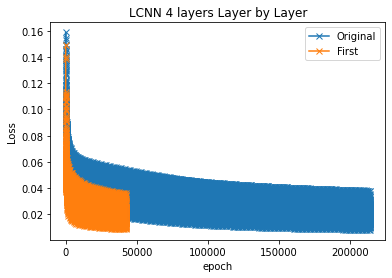

In [13]:
plt.plot(out[0][1],'x-',label='Original')
plt.plot(out[1][1],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('2 layers MSE')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

In [60]:
labels.T

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [52]:
out=[]
for p in [0,1]:
    learning_rate = 0.001
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)
    ad=False
    if p>0:
        ad=True
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)
        adjust(model,images,threshold_u=10,threshold_l=0.01,scale=1.0,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #criterion = nn.NLLLoss()
    criterion = nn.MSELoss()
    num_epochs=300
    dev=100
    losslist=[]


    totalloss=[]

    count=0
    dd=-10
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):  
            

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            
            
            
            
            totalloss.append(loss.item())
            if count<10:
                print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count=count+1
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.02:
            break
    out.append([losslist,totalloss])
    print(accuracy(model,valloader))
np.save('/content/drive/My Drive/LCNN/output2NTK.npy', out)

0 0.13020655512809753
1 0.13769212365150452
2 0.13369633257389069
3 0.1284838169813156
4 0.1273484081029892
5 0.11396662145853043
6 0.11012079566717148
7 0.10381247848272324
8 0.10041158646345139
9 0.09304777532815933
Epoch [1/300], Loss: 0.0531
Epoch [2/300], Loss: 0.0394
Epoch [3/300], Loss: 0.0353
Epoch [4/300], Loss: 0.0323
Epoch [5/300], Loss: 0.0299
Epoch [6/300], Loss: 0.0279
Epoch [7/300], Loss: 0.0262
Epoch [8/300], Loss: 0.0249
Epoch [9/300], Loss: 0.0238
Epoch [10/300], Loss: 0.0228
Epoch [11/300], Loss: 0.0220
Epoch [12/300], Loss: 0.0213
Epoch [13/300], Loss: 0.0207
Epoch [14/300], Loss: 0.0202
Epoch [15/300], Loss: 0.0197
Accuracy: 94.0000 %
None
Adjusting Layer 1, Kernel Nodes: 423, Adptive Nodes377
0 0.13020655512809753
1 0.12096523493528366
2 0.10486278682947159
3 0.10144226998090744
4 0.10842730849981308
5 0.10803365707397461
6 0.10105019062757492
7 0.09471757709980011
8 0.08747921884059906
9 0.08203642070293427
Epoch [1/300], Loss: 0.0343
Epoch [2/300], Loss: 0.0221


In [32]:
accuracy(model,valloader)

Accuracy: 97.4700 %


In [69]:
def one_hot(x, num_classes):

	return torch.eye(num_classes)[x,:]

In [70]:
one_hot(labels,10)

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],


In [50]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

Text(0.5, 0, 'Step')

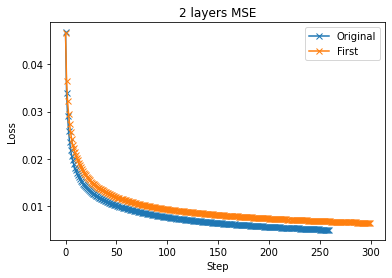

In [30]:
plt.plot(out[0][0],'x-',label='Original')
plt.plot(out[1][0],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('2 layers MSE')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'Step')

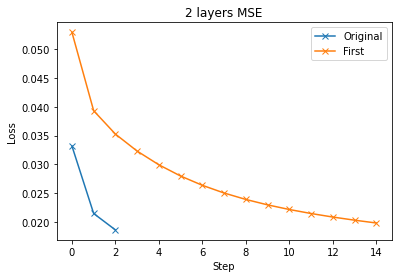

In [51]:
plt.plot(out[0][0],'x-',label='Original')
plt.plot(out[1][0],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('2 layers MSE')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

## Sparsity Data


### MSE

In [62]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hs1=1000

hidden_size1 = hs1

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().uniform_(-1, 1)
        #self.fc1.bias.detach().uniform_(-1, 1)
        self.lsm=nn.LogSoftmax(dim=1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)

    
    def forward(self, x):
        out = self.fc1(x)
        #out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = out/np.sqrt(hidden_size1)
        out = self.lsm(out)
        return out

out=[]
for p in [1,0]:
    learning_rate = 0.005
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)
    ad=False
    if p>0:
        ad=True
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)
        adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    #criterion = nn.MSELoss()
    num_epochs=300
    dev=100
    losslist=[]


    totalloss=[]
    aclist=[]

    count=0
    dd=-10
    de=1
    lo=0
    aco=0
    ts=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):  
            if i>ts:
                break

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            #labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            
            
            
            
            totalloss.append(loss.item())
            if count<5:
                print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count=count+1
                        
            
        #loss_epoch=loss_epoch/len(train_loader)
        loss_epoch=loss_epoch/ts
        losslist.append(loss_epoch)
        ac=(accuracy(model,valloader))
        aclist.append(ac)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.001 or np.abs(loss_epoch-lo)<0.00001: #or aco>ac:
            break

        lo=loss_epoch
        aco=ac
    
    out.append([losslist,totalloss,aclist])
    

Adjusting Layer 1, Kernel Nodes: 631, Adptive Nodes369
0 2.2735085487365723
1 2.209038496017456
Accuracy: 42.8700 %
Epoch [1/300], Loss: 4.4825
2 1.683534860610962
3 1.4106019735336304
Accuracy: 50.9100 %
Epoch [2/300], Loss: 3.0941
4 1.1924281120300293
Accuracy: 59.5600 %
Epoch [3/300], Loss: 2.0406
Accuracy: 67.1700 %
Epoch [4/300], Loss: 1.3397
Accuracy: 70.0000 %
Epoch [5/300], Loss: 0.9717
Accuracy: 69.6700 %
Epoch [6/300], Loss: 0.7356
Accuracy: 70.2100 %
Epoch [7/300], Loss: 0.5848
Accuracy: 70.7800 %
Epoch [8/300], Loss: 0.4841
Accuracy: 70.5900 %
Epoch [9/300], Loss: 0.4050
Accuracy: 70.1700 %
Epoch [10/300], Loss: 0.3404
Accuracy: 70.3300 %
Epoch [11/300], Loss: 0.2920
Accuracy: 70.8900 %
Epoch [12/300], Loss: 0.2542
Accuracy: 71.1200 %
Epoch [13/300], Loss: 0.2241
Accuracy: 71.1100 %
Epoch [14/300], Loss: 0.1991
Accuracy: 71.1600 %
Epoch [15/300], Loss: 0.1773
Accuracy: 70.9700 %
Epoch [16/300], Loss: 0.1594
Accuracy: 71.2800 %
Epoch [17/300], Loss: 0.1445
Accuracy: 71.5600 

In [ ]:
hao

Text(0.5, 0, 'Step')

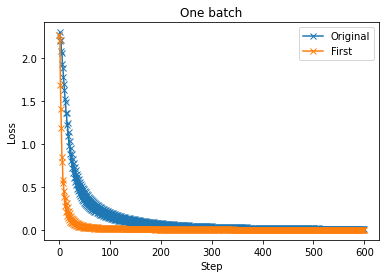

In [65]:
plt.plot(out[1][1],'x-',label='Original')
plt.plot(out[0][1],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'epoch')

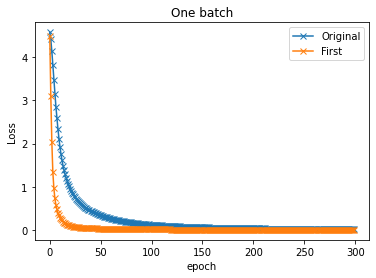

In [64]:
plt.plot(out[1][0],'x-',label='Original')
plt.plot(out[0][0],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

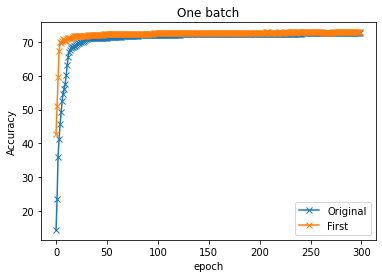

In [67]:
plt.plot(out[1][2],'x-',label='Original')
plt.plot(out[0][2],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')

## Node sparisity

In [69]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hs1=15

hidden_size1 = hs1

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().uniform_(-1, 1)
        #self.fc1.bias.detach().uniform_(-1, 1)
        self.lsm=nn.LogSoftmax(dim=1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)

    
    def forward(self, x):
        out = self.fc1(x)
        #out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = out/np.sqrt(hidden_size1)
        out = self.lsm(out)
        return out

out=[]
for p in [1,0]:
    learning_rate = 0.05
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)
    ad=False
    if p>0:
        ad=True
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)
        adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.8,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    #criterion = nn.MSELoss()
    num_epochs=300
    dev=100
    losslist=[]


    totalloss=[]
    aclist=[]

    count=0
    dd=-10
    de=1
    lo=0
    aco=0
    ts=len(train_loader)
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):  
            if i>ts:
                break

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            #labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            
            
            
            
            totalloss.append(loss.item())
            if count<5:
                print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            count=count+1
                        
            
        #loss_epoch=loss_epoch/len(train_loader)
        loss_epoch=loss_epoch/ts
        losslist.append(loss_epoch)
        ac=(accuracy(model,valloader))
        aclist.append(ac)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.001 or np.abs(loss_epoch-lo)<0.001: #or aco>ac:
            break

        lo=loss_epoch
        aco=ac
    
    out.append([losslist,totalloss,aclist])
    

Adjusting Layer 1, Kernel Nodes: 5, Adptive Nodes10
0 2.3407697677612305
1 2.720384120941162
2 2.6706860065460205
3 3.0466556549072266
4 2.547048330307007
Accuracy: 77.4400 %
Epoch [1/300], Loss: 0.7283
Accuracy: 80.0400 %
Epoch [2/300], Loss: 0.5920
Accuracy: 76.3600 %
Epoch [3/300], Loss: 0.5531
Accuracy: 80.7000 %
Epoch [4/300], Loss: 0.5379
Accuracy: 81.6800 %
Epoch [5/300], Loss: 0.5174
Accuracy: 81.1300 %
Epoch [6/300], Loss: 0.5193
Accuracy: 81.8500 %
Epoch [7/300], Loss: 0.5071
Accuracy: 80.9200 %
Epoch [8/300], Loss: 0.4983
Accuracy: 79.2700 %
Epoch [9/300], Loss: 0.4883
Accuracy: 81.3300 %
Epoch [10/300], Loss: 0.4775
Accuracy: 81.8500 %
Epoch [11/300], Loss: 0.4751
Accuracy: 81.2500 %
Epoch [12/300], Loss: 0.4717
Accuracy: 81.0000 %
Epoch [13/300], Loss: 0.4647
Accuracy: 81.2000 %
Epoch [14/300], Loss: 0.4669
Accuracy: 81.0800 %
Epoch [15/300], Loss: 0.4677
0 2.3407697677612305
1 2.227464437484741
2 2.1071791648864746
3 2.090221643447876
4 1.8810890913009644
Accuracy: 81.300

Text(0.5, 0, 'Step')

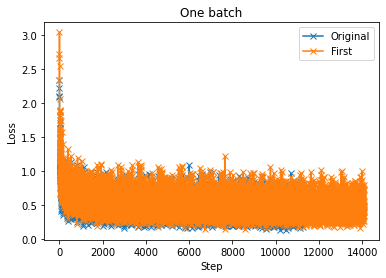

In [70]:
plt.plot(out[1][1],'x-',label='Original')
plt.plot(out[0][1],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

Text(0.5, 0, 'epoch')

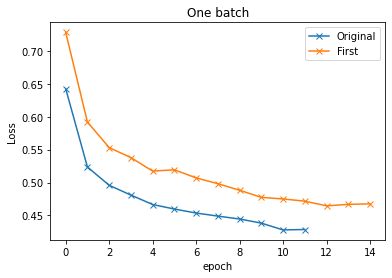

In [71]:
plt.plot(out[1][0],'x-',label='Original')
plt.plot(out[0][0],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

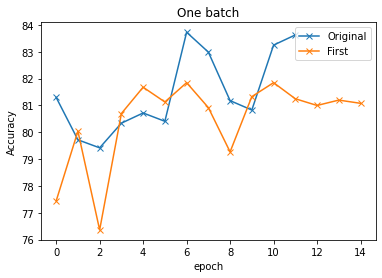

In [72]:
plt.plot(out[1][2],'x-',label='Original')
plt.plot(out[0][2],'x-',label='First')


#plt.plot(totalloss[:400],'x-',label='layer by layer')
#plt.plot([50,50],[0,2.5],color='black')
plt.title('One batch')
#plt.savefig('/content/drive/My Drive/LCNN/plot/4Shuffle2.pdf')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')